In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
from scipy.sparse import csr_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [9]:
!pip list

Package                           Version      Editable project location
--------------------------------- ------------ -------------------------
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.3.4
asttokens                         2.0.5
async-lr

In [12]:
import pkgutil, sys
used_pkgs = sorted({module.name for module in pkgutil.iter_modules() if module.name in sys.modules})
with open("requirements.txt", "w") as f:
	for pkg in used_pkgs:
		try:
			version = __import__(pkg).__version__
			f.write(f"{pkg}=={version}\n")
		except:
			pass

print("requirements.txt saved.")

requirements.txt saved.


In [3]:
# defination the function to optimize the memory usage of the dataframe
def optimize_dataframe_for_memory(df):
 print("current memory usage: ", df.memory_usage().sum() / 1024**2, "MB")

 for col in df.columns:
  _max = df[col].max()
  _min = df[col].min()
  if df[col].dtype  == 'int64':
   if _min > np.iinfo(np.int8).min and _max < np.iinfo(np.int8).max:
    df[col] = df[col].astype(np.int8)
   elif _min > np.iinfo(np.int16).min and _max < np.iinfo(np.int16).max:
    df[col] = df[col].astype(np.int16)
   elif _min > np.iinfo(np.int32).min and _max < np.iinfo(np.int32).max:
    df[col] = df[col].astype(np.int32)
  elif df[col].dtype == 'float64':
   if _min > np.finfo(np.float16).min and _max < np.finfo(np.float16).max:
    df[col] = df[col].astype(np.float16)
   elif _min > np.finfo(np.float32).min and _max < np.finfo(np.float32).max:
    df[col] = df[col].astype(np.float32)
  else:
   continue
 
 print("new memory usage: ", df.memory_usage().sum() / 1024**2, "MB")
 return df

In [4]:
order_products_train = optimize_dataframe_for_memory(pd.read_csv("C:/Users/IRIS/Desktop/order_products__train.csv"))
order_products_prior = optimize_dataframe_for_memory(pd.read_csv("C:/Users/IRIS/Desktop/order_products__prior.csv", encoding='latin1'))
orders = optimize_dataframe_for_memory(pd.read_csv("C:/Users/IRIS/Desktop/orders.csv"))
products = optimize_dataframe_for_memory(pd.read_csv("C:/Users/IRIS/Desktop/products.csv"))
aisles = optimize_dataframe_for_memory(pd.read_csv("C:/Users/IRIS/Desktop/aisles.csv"))
departments = optimize_dataframe_for_memory(pd.read_csv("C:/Users/IRIS/Desktop/departments.csv"))

current memory usage:  42.25528335571289 MB
new memory usage:  13.204862594604492 MB
current memory usage:  989.8221778869629 MB
new memory usage:  340.25145626068115 MB
current memory usage:  182.70566940307617 MB
new memory usage:  68.51470470428467 MB
current memory usage:  1.5164833068847656 MB
new memory usage:  0.7109184265136719 MB
current memory usage:  0.002170562744140625 MB
new memory usage:  0.00140380859375 MB
current memory usage:  0.000446319580078125 MB
new memory usage:  0.00030612945556640625 MB


In [15]:
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [16]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [17]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [18]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [19]:
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [20]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [21]:
user_eval_counts = orders.groupby("eval_set")["user_id"].nunique()
print(user_eval_counts)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64


In [28]:
user_order_count = orders['user_id'].value_counts()
no_order_users = user_order_count[user_order_count == 0]
one_order_users = user_order_count[user_order_count == 1]
print(one_order_users)
print(no_order_users)
print(user_order_count)

product_purchase_count = order_products_prior['product_id'].value_counts()
low_purchase_products = product_purchase_count[product_purchase_count <= 1]
print(f"Number of products with low purchase count (<=1): {len(low_purchase_products)}")

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
user_id
152340    100
185641    100
185524    100
81678     100
70922     100
         ... 
13046       4
70208       4
111440      4
31762       4
47980       4
Name: count, Length: 206209, dtype: int64
Number of products with low purchase count (<=1): 131


In [11]:
#Merge products, aisles, and departments into a single dataframe
products_with_aisles = pd.merge(products, aisles, on="aisle_id", how="left")
final_merged_data = pd.merge(products_with_aisles, departments, on="department_id", how="left")
print(final_merged_data)

       product_id                                       product_name  \
0               1                         Chocolate Sandwich Cookies   
1               2                                   All-Seasons Salt   
2               3               Robust Golden Unsweetened Oolong Tea   
3               4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4               5                          Green Chile Anytime Sauce   
...           ...                                                ...   
49683       49684          Vodka, Triple Distilled, Twist of Vanilla   
49684       49685                 En Croute Roast Hazelnut Cranberry   
49685       49686                                   Artisan Baguette   
49686       49687         Smartblend Healthy Metabolism Dry Cat Food   
49687       49688                             Fresh Foaming Cleanser   

       aisle_id  department_id                       aisle     department  
0            61             19               cookies cakes 

In [ ]:
# 描述性分析结果形成表格
summary_data = {
    "Dataset": ["Orders", "Products", "Order Products Train", "Order Products Prior"],
    "Row Count": [orders.shape[0], products.shape[0], order_products_train.shape[0], order_products_prior.shape[0]],
    "Column Count": [orders.shape[1], products.shape[1], order_products_train.shape[1], order_products_prior.shape[1]],
    "Missing Values": [
        orders.isnull().sum().sum(),
        products.isnull().sum().sum(),
        order_products_train.isnull().sum().sum(),
        order_products_prior.isnull().sum().sum()
    ],
    "Memory Usage (MB)": [
        orders.memory_usage(deep=True).sum() / 1024**2,
        products.memory_usage(deep=True).sum() / 1024**2,
        order_products_train.memory_usage(deep=True).sum() / 1024**2,
        order_products_prior.memory_usage(deep=True).sum() / 1024**2
    ]
}

summary_table = pd.DataFrame(summary_data)
print(summary_table)

In [12]:
print("order_products_train missing values：\n", order_products_train.isnull().sum())
print("\norder_products_prior missing values：\n", order_products_prior.isnull().sum())
print("\norders missing values：\n", orders.isnull().sum())
print("\nproducts missing values：\n", products.isnull().sum())
print("\naisles missing values：\n", aisles.isnull().sum())
print("\ndepartments missing values：\n", departments.isnull().sum())
# Only orders dataset has missing values which means the user didn't make any orders in the prior set.

order_products_train missing values：
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

order_products_prior missing values：
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

orders missing values：
 order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

products missing values：
 product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

aisles missing values：
 aisle_id    0
aisle       0
dtype: int64

departments missing values：
 department_id    0
department       0
dtype: int64


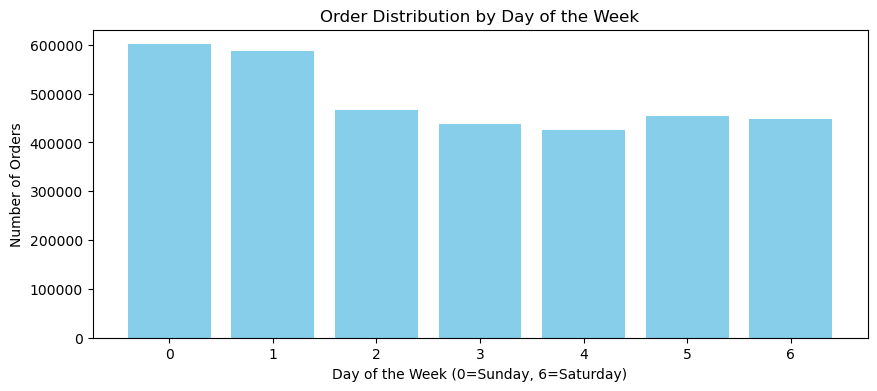

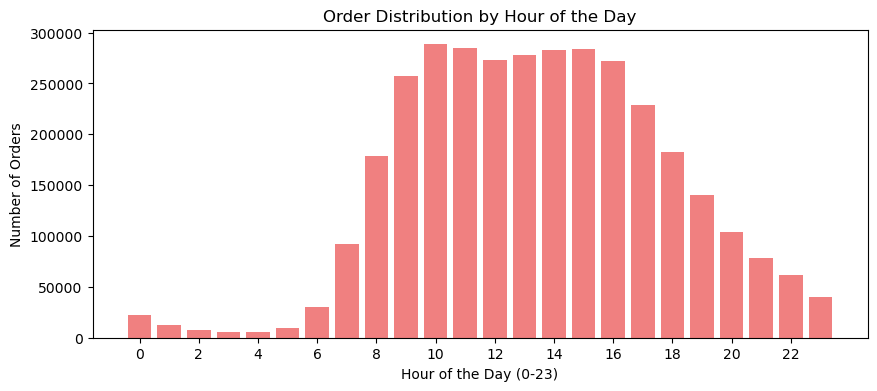

In [13]:
#What time of the day and what day of the week people tend to order more?
dow_counts = orders['order_dow'].value_counts().sort_index()
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(dow_counts.index, dow_counts.values, color='skyblue')
plt.xlabel("Day of the Week (0=Sunday, 6=Saturday)")
plt.ylabel("Number of Orders")
plt.title("Order Distribution by Day of the Week")
plt.xticks(range(7))
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(hour_counts.index, hour_counts.values, color='lightcoral')
plt.xlabel("Hour of the Day (0-23)")
plt.ylabel("Number of Orders")
plt.title("Order Distribution by Hour of the Day")
plt.xticks(range(0, 24, 2))  
plt.show()

#Sunday is the day with the most orders and the most orders are made between 10 am and 4 pm.
#While the least orders are made on Wednesday and the least orders are made between 2 am and 6 am.

    product_id   sales
0        24852  472565
1        13176  379450
2        21137  264683
3        21903  241921
4        47209  213584
5        47766  176815
6        47626  152657
7        16797  142951
8        26209  140627
9        27845  137905
10       27966  137057
11       22935  113426
12       24964  109778
13       45007  104823
14       39275  100060
15       49683   97315
16       28204   89632
17        5876   87746
18        8277   85020
19       40706   84255


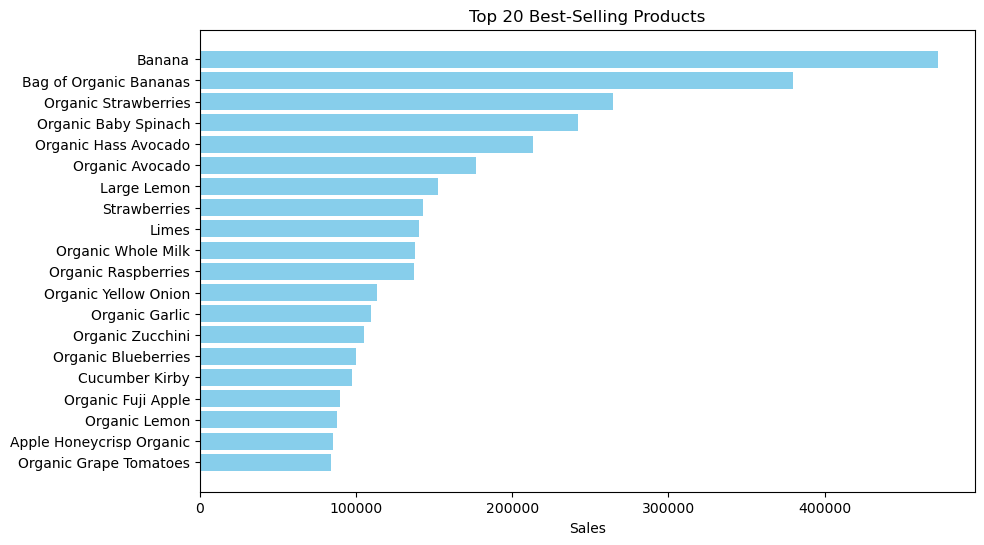

In [14]:
# Top 20 best-selling products
product_sales = order_products_prior.groupby('product_id').size().reset_index(name='sales')
top_selling_products = product_sales.sort_values(by='sales', ascending=False).head(20).reset_index(drop=True)
top_selling_product_names = products.set_index('product_id').loc[top_selling_products['product_id']]['product_name'].values
print(top_selling_products)
plt.figure(figsize=(10, 6))
plt.barh(top_selling_product_names, top_selling_products['sales'], color='skyblue')
plt.xlabel('Sales')
plt.title('Top 20 Best-Selling Products')
plt.gca().invert_yaxis()  
plt.show()
# The Top 20 best-selling products are mostly fruits and vegetables which are daily necessities.

Reorder count and reorder rate for products:
       product_id  reorder_count  reorder_rate  \
0               1             49      0.644737   
1               2              1      0.250000   
2               3              6      1.000000   
3               4             14      0.636364   
4               5              1      1.000000   
...           ...            ...           ...   
39118       49682              0      0.000000   
39119       49683           1709      0.708247   
39120       49686              5      0.714286   
39121       49687              0      0.000000   
39122       49688              1      0.250000   

                                            product_name  aisle_id  \
0                             Chocolate Sandwich Cookies        61   
1                                       All-Seasons Salt       104   
2                   Robust Golden Unsweetened Oolong Tea        94   
3      Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4   

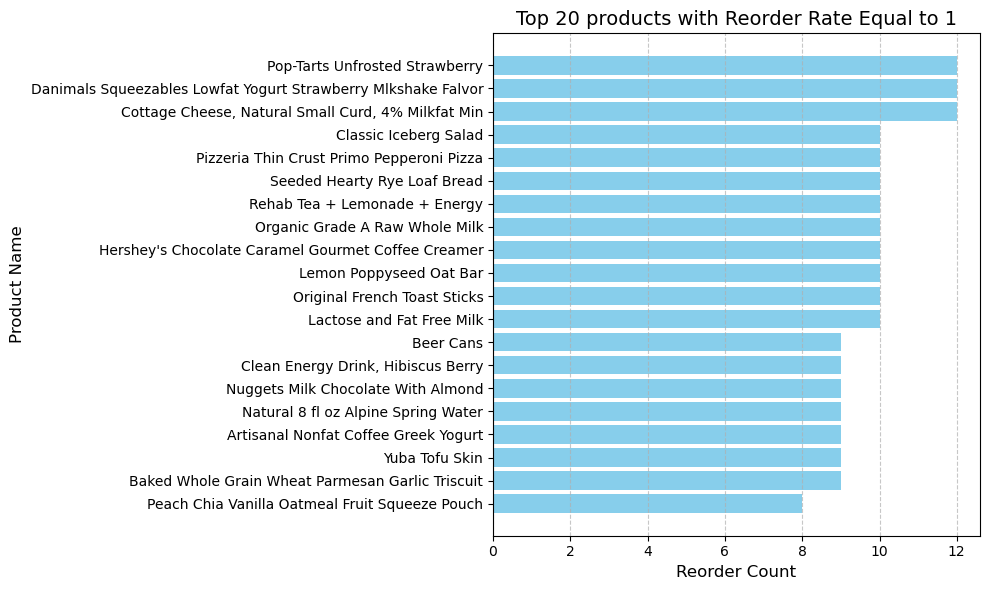

In [15]:
# Calculate reorder count and reorder rate
reorder_counts = order_products_train.groupby('product_id')['reordered'].sum().reset_index(name='reorder_count')
reorder_counts['reorder_rate'] = reorder_counts['reorder_count'] / order_products_train.groupby('product_id')['reordered'].count().values
reorder_counts_with_names = pd.merge(reorder_counts, products, on='product_id')
print("Reorder count and reorder rate for products:")
print(reorder_counts_with_names)


# Filter Top 20 products with Reorder Rate Equal to 1
high_reorder_rate_products = reorder_counts_with_names[reorder_counts_with_names['reorder_rate'] == 1]
high_reorder=high_reorder_rate_products.sort_values(by='reorder_count', ascending=False).head(20).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.barh(high_reorder['product_name'], high_reorder['reorder_count'], color='skyblue')
plt.xlabel('Reorder Count', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.title('Top 20 products with Reorder Rate Equal to 1', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

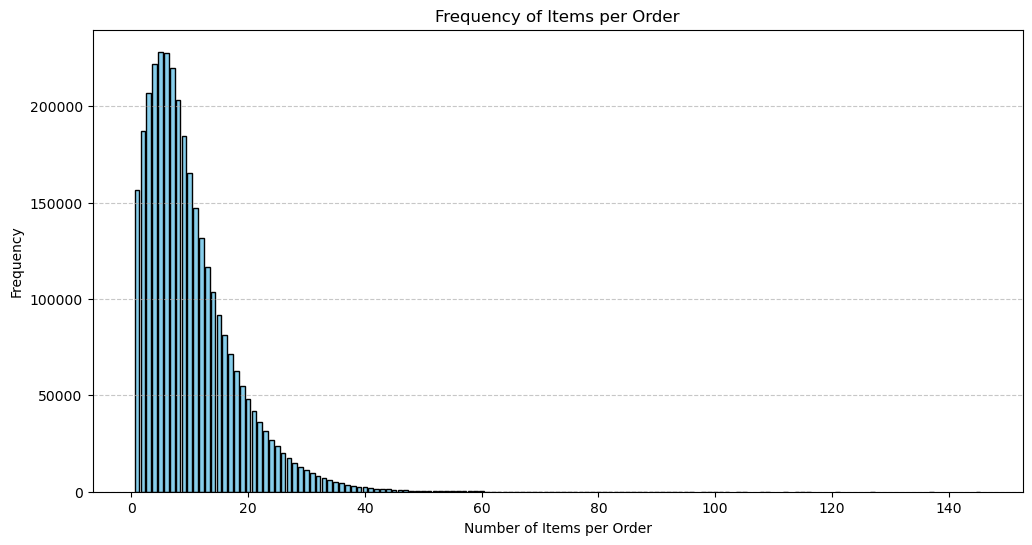

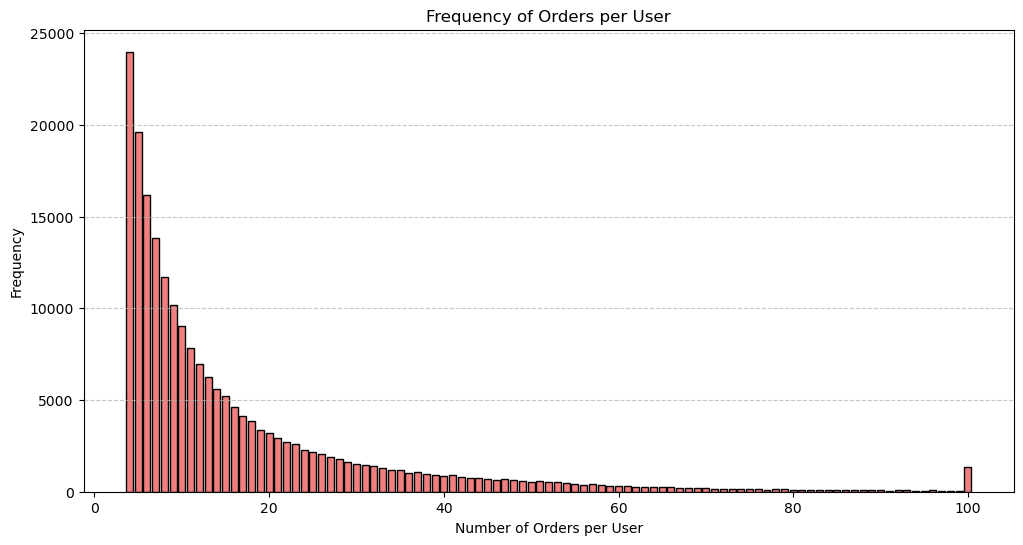

In [16]:
# frequency of items per order and orders per user
items_per_order = order_products_prior.groupby('order_id').size().reset_index(name='item_count')
orders_per_user = orders.groupby('user_id').size().reset_index(name='order_count')
items_per_order_freq = items_per_order['item_count'].value_counts().sort_index()
orders_per_user_freq = orders_per_user['order_count'].value_counts().sort_index()

# Plot frequency of items per order
plt.figure(figsize=(12, 6))
plt.bar(items_per_order_freq.index, items_per_order_freq.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Items per Order')
plt.ylabel('Frequency')
plt.title('Frequency of Items per Order')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot frequency of orders per user
plt.figure(figsize=(12, 6))
plt.bar(orders_per_user_freq.index, orders_per_user_freq.values, color='lightcoral', edgecolor='black')
plt.xlabel('Number of Orders per User')
plt.ylabel('Frequency')
plt.title('Frequency of Orders per User')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [17]:
#RFM Analysis
all_order_products = pd.concat([order_products_prior, order_products_train])
recency_df = orders.groupby("user_id")["days_since_prior_order"].min().reset_index()
recency_df.rename(columns={"days_since_prior_order": "Recency"}, inplace=True)
frequency_df = orders.groupby("user_id")["order_number"].max().reset_index()
frequency_df.rename(columns={"order_number": "Frequency"}, inplace=True)
monetary_df = all_order_products.groupby("order_id").size().reset_index(name="num_products")
monetary_df = orders.merge(monetary_df, on="order_id").groupby("user_id")["num_products"].sum().reset_index()
monetary_df.rename(columns={"num_products": "Monetary"}, inplace=True)

rfm_df = recency_df.merge(frequency_df, on="user_id").merge(monetary_df, on="user_id")
print(rfm_df.head())


   user_id  Recency  Frequency  Monetary
0        1      0.0         11        70
1        2      3.0         15       226
2        3      7.0         13        88
3        4      0.0          6        18
4        5      6.0          5        46


               user_id    Recency  Frequency    Monetary
Cluster                                                 
0        103112.903242   4.453528   9.996770   86.332049
1        102692.442637   0.688730  66.467549  805.276338
2        103081.390152   1.666808  31.615121  315.939540
3        103267.865082  20.585775   5.589902   49.825281


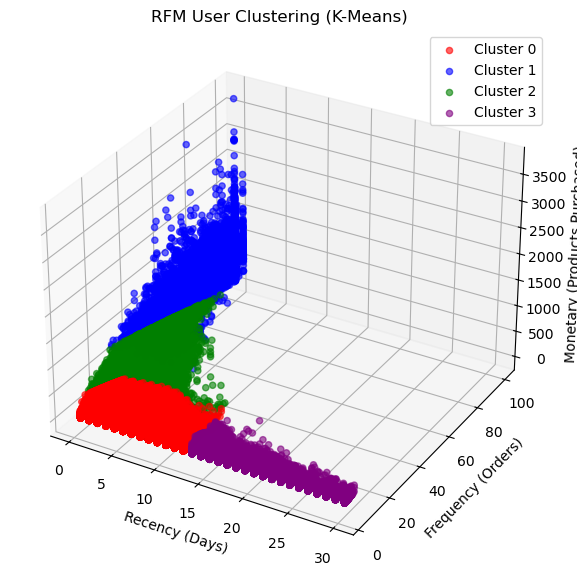

In [ ]:
# K-Means Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[["Recency", "Frequency", "Monetary"]])
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df["Cluster"] = kmeans.fit_predict(rfm_scaled)
print(rfm_df.groupby("Cluster").mean())

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green', 'purple']
for cluster in range(4):
    subset = rfm_df[rfm_df["Cluster"] == cluster]
    ax.scatter(subset["Recency"], subset["Frequency"], subset["Monetary"], 
               color=colors[cluster], label=f"Cluster {cluster}", alpha=0.6)
ax.set_xlabel("Recency (Days)")
ax.set_ylabel("Frequency (Orders)")
ax.set_zlabel("Monetary (Products Purchased)")
ax.set_title("RFM User Clustering (K-Means)")
ax.legend()
plt.show()
#Cluster 0 (Red): Medium frequency and spending, recent purchases → Regular active users.
#Cluster 1 (Blue): Low frequency and spending, recent purchases → New or occasional users.
#Cluster 2 (Green): Low frequency and spending, long time since last purchase → Churned users.
#Cluster 3 (Purple): High frequency and spending, recent purchases → High-value (VIP) users.
#K-means can separate users clearly into 4 clusters.

In [19]:
# Use Apriori Algorithm to find association rules
order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left')
top_products = order_products['product_id'].value_counts().head(1000).index
order_products = order_products[order_products['product_id'].isin(top_products)]
recent_orders = order_products['order_id'].drop_duplicates().tail(500000)
order_products = order_products[order_products['order_id'].isin(recent_orders)]

basket = (
    order_products
    .groupby(['order_id', 'product_name'])['reordered']
    .max()
    .unstack(fill_value=0)
)

basket = basket.applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules_sorted_by_confidence = rules.sort_values(by=['lift','confidence', 'support'], ascending=False)
print(rules_sorted_by_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
# Cost too much time to run the algorithm and due to the limitation of the computer, the maximum number of orders is set to 500000.

C:\Users\IRIS\AppData\Local\Temp\ipykernel_29508\4269309026.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\IRIS\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                 antecedents               consequents   support  confidence  \
2     (Organic Hass Avocado)  (Bag of Organic Bananas)  0.016750    0.291548   
3   (Bag of Organic Bananas)    (Organic Hass Avocado)  0.016750    0.158040   
4      (Organic Raspberries)  (Bag of Organic Bananas)  0.010266    0.285484   
5   (Bag of Organic Bananas)     (Organic Raspberries)  0.010266    0.096862   
15    (Organic Hass Avocado)    (Organic Strawberries)  0.010236    0.178166   
14    (Organic Strawberries)    (Organic Hass Avocado)  0.010236    0.148451   
8                   (Banana)         (Organic Avocado)  0.013270    0.099414   
9          (Organic Avocado)                  (Banana)  0.013270    0.294902   
6     (Organic Strawberries)  (Bag of Organic Bananas)  0.015624    0.226592   
7   (Bag of Organic Bananas)    (Organic Strawberries)  0.015624    0.147416   

        lift  
2   2.750814  
3   2.750814  
4   2.693600  
5   2.693600  
15  2.583915  
14  2.583915  
8   2.209302  

In [20]:
# consider using FP-Growth algorithm
order_products = pd.concat([order_products_train, order_products_prior], ignore_index=True)
order_products = order_products.merge(products[['product_id', 'product_name']], on='product_id', how='left')
top_products = order_products['product_id'].value_counts().nlargest(1000).index
order_products = order_products[order_products['product_id'].isin(top_products)]
recent_order_ids = order_products['order_id'].unique()[-500000:]
order_products = order_products[order_products['order_id'].isin(recent_order_ids)]
basket_sparse = order_products.groupby(['order_id', 'product_name'])['reordered'].max().unstack(fill_value=0)
basket_sparse = (basket_sparse > 0).astype(int) 
basket_sparse = csr_matrix(basket_sparse) 
basket_df = pd.DataFrame.sparse.from_spmatrix(basket_sparse, index=basket.index, columns=basket.columns)
frequent_itemsets_fp = fpgrowth(basket_df, min_support=0.01, use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.0)
rules_fp_sorted_by_confidence = rules_fp.sort_values(by=['lift','confidence', 'support'], ascending=False)
print(rules_fp_sorted_by_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
# we can find that the FP-Growth algorithm is much faster than the Apriori algorithm.
# However, FP-growth as a tree-based algorithm also needs too many memory resources.

c:\Users\IRIS\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                 antecedents               consequents   support  confidence  \
0     (Organic Hass Avocado)  (Bag of Organic Bananas)  0.016750    0.291548   
1   (Bag of Organic Bananas)    (Organic Hass Avocado)  0.016750    0.158040   
4      (Organic Raspberries)  (Bag of Organic Bananas)  0.010266    0.285484   
5   (Bag of Organic Bananas)     (Organic Raspberries)  0.010266    0.096862   
3     (Organic Hass Avocado)    (Organic Strawberries)  0.010236    0.178166   
2     (Organic Strawberries)    (Organic Hass Avocado)  0.010236    0.148451   
10                  (Banana)         (Organic Avocado)  0.013270    0.099414   
11         (Organic Avocado)                  (Banana)  0.013270    0.294902   
14    (Organic Strawberries)  (Bag of Organic Bananas)  0.015624    0.226592   
15  (Bag of Organic Bananas)    (Organic Strawberries)  0.015624    0.147416   

        lift  
0   2.750814  
1   2.750814  
4   2.693600  
5   2.693600  
3   2.583915  
2   2.583915  
10  2.209302  

In [21]:
# By using chunks and sparse matrix, we can reduce the memory usage and up the number of orders to 1,000,000.
order_products = pd.concat([order_products_train, order_products_prior], ignore_index=True)
top_products = order_products['product_id'].value_counts().nlargest(5000).index
order_products = order_products[order_products['product_id'].isin(top_products)]
order_products = order_products.drop_duplicates(subset=['order_id', 'product_id']).tail(1000000)
order_products = order_products.merge(products[['product_id', 'product_name']], on='product_id', how='left')
chunks = np.array_split(order_products, 5) 
baskets = []

for chunk in chunks:
    basket = chunk.pivot_table(index='order_id', columns='product_name', values='reordered', aggfunc='max', fill_value=0)
    basket = (basket > 0).astype(int) 
    baskets.append(basket)

basket = pd.concat(baskets)

basket_sparse = csr_matrix(basket.values)

basket_df = pd.DataFrame.sparse.from_spmatrix(basket_sparse, index=basket.index, columns=basket.columns)

frequent_itemsets_fp = fpgrowth(basket_df, min_support=0.01, use_colnames=True)

rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.0)
rules_fp_sorted_by_confidence = rules_fp.sort_values(by=['lift','confidence', 'support'], ascending=False)

print(rules_fp_sorted_by_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

c:\Users\IRIS\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\IRIS\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                 antecedents               consequents   support  confidence  \
11  (Bag of Organic Bananas)    (Organic Hass Avocado)  0.015282    0.152612   
10    (Organic Hass Avocado)  (Bag of Organic Bananas)  0.015282    0.283761   
9          (Organic Avocado)                  (Banana)  0.012277    0.291418   
8                   (Banana)         (Organic Avocado)  0.012277    0.098338   
2     (Organic Strawberries)  (Bag of Organic Bananas)  0.015173    0.232585   
3   (Bag of Organic Bananas)    (Organic Strawberries)  0.015173    0.151525   
4   (Bag of Organic Bananas)    (Organic Baby Spinach)  0.011608    0.115921   
5     (Organic Baby Spinach)  (Bag of Organic Bananas)  0.011608    0.199110   
7     (Organic Baby Spinach)                  (Banana)  0.011599    0.198966   
6                   (Banana)    (Organic Baby Spinach)  0.011599    0.092908   

        lift  
11  2.833812  
10  2.833812  
9   2.334199  
8   2.334199  
2   2.322740  
3   2.322740  
4   1.988437  

In [ ]:
#As we want to find the association rules for each department.
order_products = pd.concat([order_products_train, order_products_prior], ignore_index=True)
order_products = order_products.drop_duplicates(subset=['order_id', 'product_id']).tail(500000)
order_products['product_id'] = order_products['product_id'].astype(int)
products['product_id'] = products['product_id'].astype(int)
order_products = order_products.merge(products[['product_id', 'product_name', 'department_id']], on='product_id', how='left')
sales_count = order_products.groupby('product_id').size().reset_index(name='sales_count')
reorder_rate = order_products.groupby('product_id')['reordered'].mean().reset_index(name='reorder_rate')
product_stats = sales_count.merge(reorder_rate, on='product_id')

# min-max scaling of sales count and reorder rate
scaler = MinMaxScaler()
product_stats[['sales_count', 'reorder_rate']] = scaler.fit_transform(product_stats[['sales_count', 'reorder_rate']])

# give score to each product based on sales count and reorder rate
product_stats['score'] = 0.6 * product_stats['sales_count'] + 0.4 * product_stats['reorder_rate']
product_stats = product_stats.merge(products[['product_id', 'department_id']], on='product_id', how='left')
# get top 100 products for each department
top_products_by_department = (
    product_stats.groupby('department_id')
    .apply(lambda x: x.nlargest(100, 'score'))
    .reset_index(drop=True)
)
#find the association rules without grouping by department
top_products = top_products_by_department['product_id'].unique()
order_products_filtered = order_products[order_products['product_id'].isin(top_products)]
order_products_filtered.loc[:, 'reordered'] = order_products_filtered['reordered'].fillna(0).astype(int)
basket = order_products_filtered.pivot_table(index='order_id', columns='product_name', values='reordered', aggfunc='max', fill_value=0)
basket = (basket > 0).astype(bool)
frequent_itemsets = fpgrowth(basket, min_support=0.0001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)


rules_sorted = rules.sort_values(by=['lift', 'confidence', 'support'], ascending=False)
rules_sorted['antecedents'] = rules_sorted['antecedents'].apply(lambda x: frozenset(sorted(x)))
rules_sorted['consequents'] = rules_sorted['consequents'].apply(lambda x: frozenset(sorted(x)))
rules_sorted = rules_sorted.drop_duplicates(subset=['antecedents', 'consequents'])

association_results = rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
product_to_department = products.set_index('product_name')['department_id'].to_dict()
def get_departments(itemset):
    return frozenset(product_to_department[product] for product in itemset if product in product_to_department)

association_results['antecedent_departments'] = association_results['antecedents'].apply(get_departments)
association_results['consequent_departments'] = association_results['consequents'].apply(get_departments)
# filter the results to show only the top 20 rules for each department
filtered_results = (
    association_results.groupby('antecedent_departments')
    .apply(lambda x: x.nlargest(20, ['lift', 'confidence', 'support']))
    .reset_index(drop=True)
)

filtered_results.to_csv('filtered_association_results.csv')
print(filtered_results[['antecedents', 'antecedent_departments', 'consequents', 'consequent_departments', 'support', 'confidence', 'lift']])
# Most of products are origanic and healthy food, which are daily necessities.
# While there also some interesting association rules like 'Boneless Skinless Chicken Breasts'——'Banana', 'Honeycrisp Apple', 'Organic Avocado' 
# Fruit and vetegables are not only bought together but also bought with other products.
# By using the association rules, the company can make better recommendations to the customers and increase the sales.

                                           antecedents antecedent_departments  \
0           (Organic Cashew Nondairy Blueberry Yogurt)                   (21)   
1          (Organic Nondairy Strawberry Cashew Yogurt)                   (21)   
2                          (Organic Riced Cauliflower)                   (21)   
3                          (Organic Riced Cauliflower)                   (21)   
4                          (Organic Riced Cauliflower)                   (21)   
..                                                 ...                    ...   
264  (Boneless Skinless Chicken Breasts, Banana, Or...            (16, 12, 4)   
265  (Honeycrisp Apple, Boneless Skinless Chicken B...            (16, 4, 12)   
266  (Boneless Skinless Chicken Breasts, Banana, Or...            (16, 12, 4)   
267  (Organic Whole Milk, Boneless Skinless Chicken...            (16, 12, 4)   
268  (Boneless Skinless Chicken Breasts, Sparkling ...                (12, 7)   

                           

C:\Users\IRIS\AppData\Local\Temp\ipykernel_29508\1611559610.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  association_results['antecedent_departments'] = association_results['antecedents'].apply(get_departments)
C:\Users\IRIS\AppData\Local\Temp\ipykernel_29508\1611559610.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  association_results['consequent_departments'] = association_results['consequents'].apply(get_departments)
